In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio

from numpy import sqrt, pi, exp, transpose, matmul
from numpy.linalg import det, inv   

%matplotlib inline


In [2]:
image_files = glob.glob("apples/*.jpg")
# Load images and normalise to [0,1] range
training_colour_images = [
    plt.imread(file)/255
    for file in image_files
]

training_mask_files = glob.glob("apples/*.png")
# Load masks and get rid of the colour dimension
training_mask_images = [
    plt.imread(file)[:,:,1]
    for file in training_mask_files
]

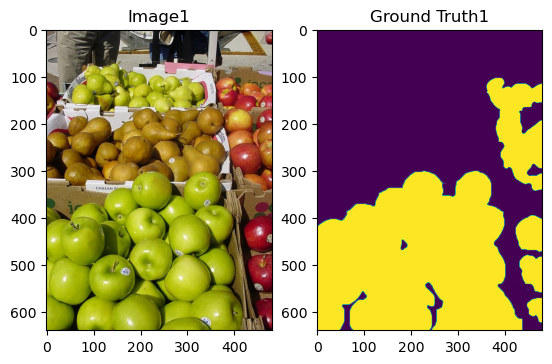

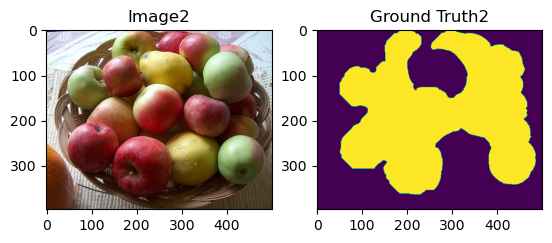

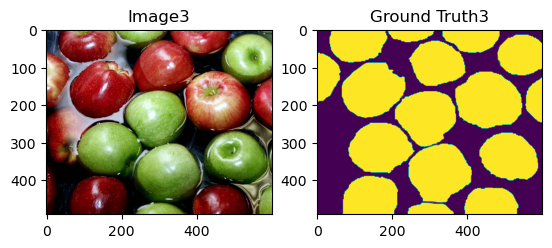

In [3]:
# display the test image and the ground truth mask
for i in range(len(training_colour_images)):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(training_colour_images[i])
    ax1.set_title('Image' + str(i+1))
    ax2.imshow(training_mask_images[i])
    ax2.set_title('Ground Truth' + str(i+1))
    plt.show()

## Part A: Convert images and masks to RBG

In [4]:

def getRBGValues(image):
    return np.array([image[:,:,0].flatten(), image[:,:,1].flatten(), image[:,:,2].flatten()])

def getMaskValues(mask):
    return np.array([mask.flatten()])

def getRBGValuesApplesAndNonApples(training_colour_images, training_mask_images):
    RBGApples = []
    RBGNonApples = []
    for i in range(len(training_colour_images)):
        print(training_colour_images[i].shape)
        #convert to RBG,flatten and convert to float32
        training_colour_images_values = np.array(getRBGValues(training_colour_images[i]).T)
        assert training_colour_images_values.shape == (training_colour_images[i].shape[0]*training_colour_images[i].shape[1], 3)
        #convert to binary mask and flatten
        training_mask_binary_values = np.array(getMaskValues((training_mask_images[i] > 0.5).astype(int)).T)
        assert np.all((training_mask_binary_values == 0) | (training_mask_binary_values == 1)) # asset that all values are either 0 or 1
        
        #get RBG values for apples and non apples, and append to list
        RBGApples.extend((training_colour_images_values[training_mask_binary_values.flatten()==1] ))
        RBGNonApples.extend((training_colour_images_values[training_mask_binary_values.flatten()==0] ))
    
    return np.float32(np.array(RBGApples)).T, np.float32(np.array(RBGNonApples)).T

        
RBGApples, RBGNonApples = getRBGValuesApplesAndNonApples(training_colour_images, training_mask_images)
print(RBGApples.shape)
assert np.all((RBGApples >= 0) & (RBGApples <= 1)), "Array values are not in the range [0, 1]"
assert np.all((RBGNonApples >= 0) & (RBGNonApples <= 1)), "Array values are not in the range [0, 1]"

(640, 480, 3)
(397, 500, 3)
(491, 600, 3)
(3, 425703)


## Part B: Fit gaussians to Apples and Non Apples

In [5]:
def getGaussProb(x,mean,cov):   
    """
    Returns the likelihood that each data point in x belongs to the Gaussian described by mean and 
    var.
    
    Keyword arguments:
    x -- 1 by n vector of data points. n is the number of data points.
    mean -- scalar containing the mean parameter of the Gaussian distribution.
    var -- scalar containing the variance parameter of the Gaussian distribution.
    
    Returns: 
    prob -- scalar contianing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by mean and var.
    """
    d, k = mean.shape
    print('mean shape ',d, k)
    print('mean shape ',d, k)
    n = x.shape[1]
    print('x shape ', n)
    
    probabilities = np.zeros((k, n))
    for i in range(k):
        x_mean = x - mean[:,i, np.newaxis]
        #using pinv to avoid singular matrix error
        decomposition_sum = ((x_mean.T@ np.linalg.pinv(cov[:,:,i])) * x_mean.T).sum(axis=1)
        probabilities[i,:] = np.exp(-0.5 * decomposition_sum)/ (((2 * np.pi)**(d/2)) * np.linalg.det(cov[:,:,i])**0.5)  
                     
    return probabilities 

In [6]:
def getMixGaussLogLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """                               
    # initialize log likelihoods                                                                       
    logLike = 0;                                                                                                                  
    probabilities = getGaussProb(data, mixGaussEst['mean'], mixGaussEst['cov'])
    likes = np.sum(mixGaussEst['weight'] * probabilities.T, axis=0)
    logLike = np.sum(np.log(likes))
    
    print('weight: ', mixGaussEst['weight'] )
    print('log like', logLike )                                               
                                                                                                       
    return logLike.item()                                                       
                                                                                                       

In [7]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape

    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))
    

    nIter = 50;
    logLikeVec = np.zeros(shape=(2 * nIter)) 

    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================
        curCov = mixGaussEst['cov']                                                                                 
        curWeight = mixGaussEst['weight']                                                                            
        curMean = mixGaussEst['mean'] 
        
        l_ik = curWeight[:, np.newaxis]*getGaussProb(data, curMean, curCov)
        postHidden = l_ik/np.sum(l_ik, axis=0)
        
        logLikeVec[2 * cIter] = logLike  
        
        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss,:])/np.sum(postHidden)
            
            mixGaussEst['mean'][:,cGauss] = np.sum(postHidden[cGauss,:]*data, axis=1)/np.sum(postHidden[cGauss,:])
            
            x_i_mu_k = data - mixGaussEst['mean'][:,cGauss][:, np.newaxis]
            mixGaussEst['cov'][:,:,cGauss] = (postHidden[cGauss,:]*x_i_mu_k)@x_i_mu_k.T/np.sum(postHidden[cGauss,:])
        
        # calculate the log likelihood
        logLike = getMixGaussLogLike(data, mixGaussEst)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))
        logLikeVec[2 * cIter + 1] = logLike
    #plotting the log likelihood    
    plt.figure()                                                                                                     
    plt.plot(logLikeVec, 'g',label='log likelihood')                                                                                        
    plt.legend()

    return mixGaussEst

mean shape  3 3
mean shape  3 3
x shape  425703


weight:  [0.33333333 0.33333333 0.33333333]
log like -41.43503641091711
Log Likelihood Iter 0 : -41.435

mean shape  3 3
mean shape  3 3
x shape  425703
mean shape  3 3
mean shape  3 3
x shape  425703
weight:  [2.65373212e-06 9.99997346e-01 3.00706910e-19]
log like -9.937285639071852
Log Likelihood After Iter 0 : -9.937

mean shape  3 3
mean shape  3 3
x shape  425703
mean shape  3 3
mean shape  3 3
x shape  425703
weight:  [6.18477326e-06 9.99993815e-01 1.61794893e-17]
log like -3.5496719700686477
Log Likelihood After Iter 1 : -3.550

mean shape  3 3
mean shape  3 3
x shape  425703
mean shape  3 3
mean shape  3 3
x shape  425703
weight:  [3.53956473e-05 9.99964604e-01 1.95151296e-15]
log like 3.625284055207466
Log Likelihood After Iter 2 : 3.625

mean shape  3 3
mean shape  3 3
x shape  425703
mean shape  3 3
mean shape  3 3
x shape  425703
weight:  [3.31906019e-04 9.99668094e-01 3.06574794e-13]
log like 11.24969738395063
Log Likelihood After Iter 3 : 11.250

mean shape  3 3
mean shap

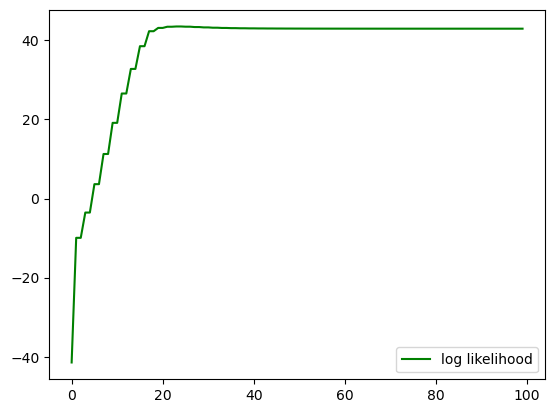

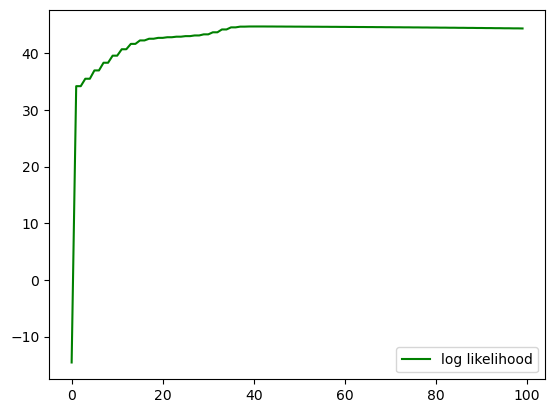

In [8]:

nGaussEstApples = 3
nGaussEstNonApples = 3

mixGaussEstApples = fitMixGauss(RBGApples,nGaussEstApples);
mixGaussEstNonApples = fitMixGauss(RBGNonApples,nGaussEstNonApples);

In [9]:

# cacluate the prior probability for apples and non apples
def calculatePriorsForApplesAndNonApples(RBGApples, RBGNonApples):
    applesPrior = RBGApples.shape[1]/(RBGApples.shape[1]+RBGNonApples.shape[1])
    nonApplesPrior = RBGNonApples.shape[1]/(RBGApples.shape[1]+RBGNonApples.shape[1])
    assert applesPrior + nonApplesPrior == 1, "Priors do not sum to 1"
    return applesPrior, nonApplesPrior


# now run through the pixels in the image and classify them as being skin or
# non skin - we will fill in the posterior
def getPosteriorApples(iamge, mixGaussEstApples, mixGaussEstNonApples):
    """
    Returns posterior probabilities of each pixel in the image belonging to the apple or non apple class.
    """
    imY, imX, imZ = iamge.shape
    posteriorApple = np.zeros([imY,imX])
    
    applesPrior, nonApplesPrior = calculatePriorsForApplesAndNonApples(RBGApples, RBGNonApples)

    for cY in range(imY): 
        
        #calculate current likelihood
        thisData = np.double(iamge[cY,:,:]).T
        print(thisData.shape)
        #thisData = thisData[:, np.newaxis]
        
        weightedProbabilitiesApple = mixGaussEstApples['weight'][:, np.newaxis]*getGaussProb(thisData, mixGaussEstApples['mean'], mixGaussEstApples['cov'])
        likelihoodApple = np.sum(weightedProbabilitiesApple, axis=0)

        weightedProbabilitiesNonApple = mixGaussEstNonApples['weight'][:, np.newaxis]*getGaussProb(thisData, mixGaussEstNonApples['mean'], mixGaussEstNonApples['cov'])
        likelihoodNonApple = np.sum(weightedProbabilitiesNonApple, axis=0)
        #calculate posterior probability
        posteriorApple[cY,:]=applesPrior*likelihoodApple/(applesPrior * likelihoodApple + nonApplesPrior * likelihoodNonApple)
    return posteriorApple

(3, 480)
mean shape  3 3
mean shape  3 3
x shape  480
mean shape  3 3
mean shape  3 3
x shape  480
(3, 480)
mean shape  3 3
mean shape  3 3
x shape  480
mean shape  3 3
mean shape  3 3
x shape  480
(3, 480)
mean shape  3 3
mean shape  3 3
x shape  480
mean shape  3 3
mean shape  3 3
x shape  480
(3, 480)
mean shape  3 3
mean shape  3 3
x shape  480
mean shape  3 3
mean shape  3 3
x shape  480
(3, 480)
mean shape  3 3
mean shape  3 3
x shape  480
mean shape  3 3
mean shape  3 3
x shape  480
(3, 480)
mean shape  3 3
mean shape  3 3
x shape  480
mean shape  3 3
mean shape  3 3
x shape  480
(3, 480)
mean shape  3 3
mean shape  3 3
x shape  480
mean shape  3 3
mean shape  3 3
x shape  480
(3, 480)
mean shape  3 3
mean shape  3 3
x shape  480
mean shape  3 3
mean shape  3 3
x shape  480
(3, 480)
mean shape  3 3
mean shape  3 3
x shape  480
mean shape  3 3
mean shape  3 3
x shape  480
(3, 480)
mean shape  3 3
mean shape  3 3
x shape  480
mean shape  3 3
mean shape  3 3
x shape  480
(3, 480)
m

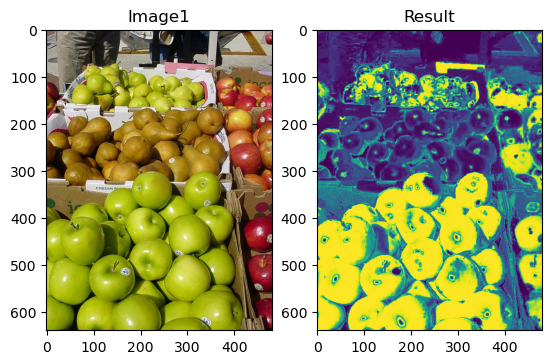

(3, 500)
mean shape  3 3
mean shape  3 3
x shape  500
mean shape  3 3
mean shape  3 3
x shape  500
(3, 500)
mean shape  3 3
mean shape  3 3
x shape  500
mean shape  3 3
mean shape  3 3
x shape  500
(3, 500)
mean shape  3 3
mean shape  3 3
x shape  500
mean shape  3 3
mean shape  3 3
x shape  500
(3, 500)
mean shape  3 3
mean shape  3 3
x shape  500
mean shape  3 3
mean shape  3 3
x shape  500
(3, 500)
mean shape  3 3
mean shape  3 3
x shape  500
mean shape  3 3
mean shape  3 3
x shape  500
(3, 500)
mean shape  3 3
mean shape  3 3
x shape  500
mean shape  3 3
mean shape  3 3
x shape  500
(3, 500)
mean shape  3 3
mean shape  3 3
x shape  500
mean shape  3 3
mean shape  3 3
x shape  500
(3, 500)
mean shape  3 3
mean shape  3 3
x shape  500
mean shape  3 3
mean shape  3 3
x shape  500
(3, 500)
mean shape  3 3
mean shape  3 3
x shape  500
mean shape  3 3
mean shape  3 3
x shape  500
(3, 500)
mean shape  3 3
mean shape  3 3
x shape  500
mean shape  3 3
mean shape  3 3
x shape  500
(3, 500)
m

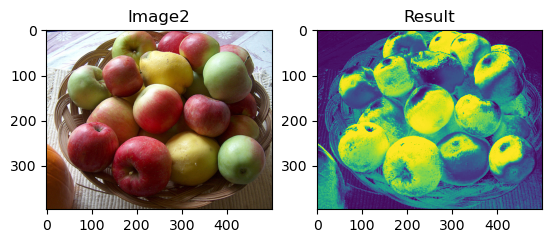

(3, 600)
mean shape  3 3
mean shape  3 3
x shape  600
mean shape  3 3
mean shape  3 3
x shape  600
(3, 600)
mean shape  3 3
mean shape  3 3
x shape  600
mean shape  3 3
mean shape  3 3
x shape  600
(3, 600)
mean shape  3 3
mean shape  3 3
x shape  600
mean shape  3 3
mean shape  3 3
x shape  600
(3, 600)
mean shape  3 3
mean shape  3 3
x shape  600
mean shape  3 3
mean shape  3 3
x shape  600
(3, 600)
mean shape  3 3
mean shape  3 3
x shape  600
mean shape  3 3
mean shape  3 3
x shape  600
(3, 600)
mean shape  3 3
mean shape  3 3
x shape  600
mean shape  3 3
mean shape  3 3
x shape  600
(3, 600)
mean shape  3 3
mean shape  3 3
x shape  600
mean shape  3 3
mean shape  3 3
x shape  600
(3, 600)
mean shape  3 3
mean shape  3 3
x shape  600
mean shape  3 3
mean shape  3 3
x shape  600
(3, 600)
mean shape  3 3
mean shape  3 3
x shape  600
mean shape  3 3
mean shape  3 3
x shape  600
(3, 600)
mean shape  3 3
mean shape  3 3
x shape  600
mean shape  3 3
mean shape  3 3
x shape  600
(3, 600)
m

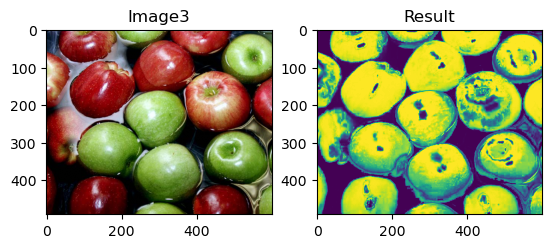

In [10]:
for i in range(len(training_colour_images)):
    posteriorApple = getPosteriorApples(training_colour_images[i], mixGaussEstApples, mixGaussEstNonApples)
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(training_colour_images[i])
    ax1.set_title('Image' + str(i+1))
    ax2.imshow(posteriorApple)
    ax2.set_title('Result')
    plt.show()